Patil fluidized bed

In [2]:
import numpy
import matplotlib.pyplot as plt
print(numpy.pi)
# define general parameters for plots
plt.rcParams["figure.figsize"] = (12.0, 8.0)

3.141592653589793


In [16]:
#auxiliary functions



def Reynolds(rho, vr, dp, mu):
    Re = rho*vr*dp/mu
    
    return Re

def Prandlt(cp, mu, k):
    Pr = cp*mu*k
    
    return Pr

def NusseltGunn(Re, Pr, alpha_f):

    Nu = (7.0 - 10.0 * alpha_f + 5.0 * alpha_f * alpha_f) * (1.0 + 0.7 * numpy.power(Re, 0.2) * numpy.power(Pr, 0.3333333333)) + \
    (1.33 - 2.4 * alpha_f + 1.2 * alpha_f * alpha_f) * numpy.power(Re, 0.7) * numpy.power(Pr, 0.3333333333)

    return Nu

def h_average(Nu, dp, k):
    h = Nu*k/dp
    
    return h

def Biot(dp, h, ks):
    Bi = dp*h/ks
    
    return Bi

In [18]:
#Pseudo 2-d bed
width = 8.0/100 #m
height = 25.0/100 #m
depth = 1.5/100 #m
center_nozzle_diameter = 1.2/100 #m
bottom_area = width*depth
nozzle_area = numpy.pi*center_nozzle_diameter*center_nozzle_diameter/4.0
inlet_area = bottom_area-nozzle_area
waal_heat_transfer_coeff = 350 #W/m2 K
print(nozzle_area/bottom_area)


#Particle properties
particle_density = 2500 #kg/m3
normal_restitution_coef = 0.97 #[ ]
tangential_restitution_coef = 0.33 #[ ]
particle_friction_coef = 0.30 #[ ]
particle_heat_capacity = 840.0 #J/kgK
particle_thermal_conductivity = 1.40 #W/mK
particle_YM = 0.e+10 #N/m2
particle_diameter = 1.0/1000 #mm
particle_volume = numpy.pi * (particle_diameter*particle_diameter*particle_diameter)/6.0
particle_mass = particle_volume*particle_density
print("particle_mass = ",particle_mass, "kg")

#Fluid properties
fluid_heat_capacity = 1010 #J/kgK
fluid_thermal_conductivity = 0.026 #W/mK
fluid_viscosity = 2.0/100000 #kg/ms
fluid_density = 1.165 #kg/m3 not from the paper

#operating_conditions
particles_initial_temperature = 90 #C
fluid_inlet_temperature = 20 #C
walls_temperature = 20 #C


#Mesh details
patil_dx = 2.28/1000 #m
patil_dy = 2.5/1000 #m
patil_dz = 2.28/1000 #m
volume_10_particles = 10.0*particle_volume/0.6
mesh_size = numpy.power(volume_10_particles, 1.0/3)
print("mesh_size = ", mesh_size)

#case settings
alpha_f = 0.4
#case 1
gas_velocity_case1 = 1.2 #m/s
gas_volume_flow_rate_case1 = bottom_area*gas_velocity_case1
gas_superficial_velocity_case1 = gas_volume_flow_rate_case1/inlet_area
bed_mass_case1 = 75.0/1000 #kg
number_of_particles_case1 = bed_mass_case1/particle_mass
Re_case1 = Reynolds(fluid_density, gas_superficial_velocity_case1/alpha_f, particle_diameter, fluid_viscosity)
Pr_case1 = Prandlt(fluid_heat_capacity, fluid_viscosity, fluid_thermal_conductivity)
Nu_case1 = NusseltGunn(Re_case1, Pr_case1, alpha_f)
h_case1 = h_average(Nu_case1, particle_diameter, fluid_thermal_conductivity)
Biot_case1 = Biot(particle_diameter, h_case1, particle_thermal_conductivity)
print(" Re_case1 = ", Re_case1)
print(" Pr_case1 = ", Pr_case1)
print(" Nu_case1 = ", Nu_case1)
print(" h_case1 = ", h_case1)
print(" Biot_case1 = ", Biot_case1)
print("number_of_particles_case1= ", number_of_particles_case1)
print("superf_velocity_case1= ", gas_superficial_velocity_case1)

#case 2
gas_velocity_case2 = 1.2 #m/s
bed_mass_case2 = 125.0/1000 #kg
gas_volume_flow_rate_case2 = bottom_area*gas_velocity_case2
gas_superficial_velocity_case2 = gas_volume_flow_rate_case2/inlet_area
number_of_particles_case2 = bed_mass_case2/particle_mass
print("number_of_particles_case2= ", number_of_particles_case2)
print("superf_velocity_case2= ", gas_superficial_velocity_case2)

#case 3
gas_velocity_case3 = 1.54 #m/s
bed_mass_case3 = 75.0/1000 #kg
gas_volume_flow_rate_case3 = bottom_area*gas_velocity_case3
gas_superficial_velocity_case3 = gas_volume_flow_rate_case3/inlet_area
number_of_particles_case3 = bed_mass_case3/particle_mass
print("number_of_particles_case3= ", number_of_particles_case3)
print("superf_velocity_case3= ", gas_superficial_velocity_case3)
Re_case3 = Reynolds(fluid_density, gas_superficial_velocity_case3/alpha_f, particle_diameter, fluid_viscosity)
Pr_case3 = Prandlt(fluid_heat_capacity, fluid_viscosity, fluid_thermal_conductivity)
Nu_case3 = NusseltGunn(Re_case3, Pr_case3, alpha_f)
h_case3 = h_average(Nu_case3, particle_diameter, fluid_thermal_conductivity)
Biot_case3 = Biot(particle_diameter, h_case3, particle_thermal_conductivity)
print(" Re_case3 = ", Re_case3)
print(" Pr_case3 = ", Pr_case3)
print(" Nu_case3 = ", Nu_case3)
print(" h_case3 = ", h_case3)
print(" Biot_case3 = ", Biot_case3)
print("number_of_particles_case3= ", number_of_particles_case3)
print("superf_velocity_case3= ", gas_superficial_velocity_case3)

#case 4
gas_velocity_case4 = 1.54 #m/s
bed_mass_case4 = 125.0/1000 #kg
gas_volume_flow_rate_case4 = bottom_area*gas_velocity_case4
gas_superficial_velocity_case4 = gas_volume_flow_rate_case4/inlet_area
number_of_particles_case4 = bed_mass_case4/particle_mass
print("number_of_particles_case4= ", number_of_particles_case4)
print("superf_velocity_case4= ", gas_superficial_velocity_case4)

#case 5
gas_velocity_case5 = 1.71 #m/s
bed_mass_case5 = 75.0/1000 #kg
gas_volume_flow_rate_case5 = bottom_area*gas_velocity_case5
gas_superficial_velocity_case5 = gas_volume_flow_rate_case5/inlet_area
number_of_particles_case5 = bed_mass_case5/particle_mass
print("number_of_particles_case5= ", number_of_particles_case5)
print("superf_velocity_case5= ", gas_superficial_velocity_case5)



0.0942477796076938
particle_mass =  1.3089969389957471e-06 kg
mesh_size =  0.00205880773218
 Re_case1 =  192.93355960453619
 Pr_case1 =  0.0005252000000000001
 Nu_case1 =  6.21905579941
 h_case1 =  161.695450785
 Biot_case1 =  0.115496750561
number_of_particles_case1=  57295.77951308232
superf_velocity_case1=  1.3248656453530383
number_of_particles_case2=  95492.9658551372
superf_velocity_case2=  1.3248656453530383
number_of_particles_case3=  57295.77951308232
superf_velocity_case3=  1.7002442448697324
 Re_case3 =  247.59806815915476
 Pr_case3 =  0.0005252000000000001
 Nu_case3 =  6.59475284518
 h_case3 =  171.463573975
 Biot_case3 =  0.12247398141
number_of_particles_case3=  57295.77951308232
superf_velocity_case3=  1.7002442448697324
number_of_particles_case4=  95492.9658551372
superf_velocity_case4=  1.7002442448697324
number_of_particles_case5=  57295.77951308232
superf_velocity_case5=  1.8879335446280792


In [4]:
#importing results
case_data = open("patil_temperature_results1.txt", 'r')
time_case1, temp_case1 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("patil_temperature_results2.txt", 'r')
time_case2, temp_case2 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("patil_temperature_results3.txt", 'r')
time_case3, temp_case3 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("patil_temperature_results4.txt", 'r')
time_case4, temp_case4 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("patil_temperature_results5.txt", 'r')
time_case5, temp_case5 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("patil_75g_volumetric_case1.csv", 'r')
x_case1, volFlux_case1 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("patil_75g_volumetric_case5.csv", 'r')
x_case5, volFlux_case5 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()



In [43]:
case_data = open("meanParticleTemperatureRocky_case1.csv", 'r')
time_rocky_case1, temp_rocky_case1 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("meanParticleTemperatureRocky_case3.csv", 'r')
time_rocky_case3, temp_rocky_case3 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("meanParticleTemperatureRocky_case3_eulerian.csv", 'r')
time_rocky_case3_eul, temp_rocky_case3_eul = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("meanParticleTemperatureRocky_case3_eulerian2.csv", 'r')
time_rocky_case3_eul2, temp_rocky_case3_eul2 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()

case_data = open("meanParticleTemperatureRocky_case3_eulerian3.csv", 'r')
time_rocky_case3_eul3, temp_rocky_case3_eul3 = numpy.loadtxt(case_data, delimiter = ',', skiprows = 1, unpack = True)    
case_data.close()


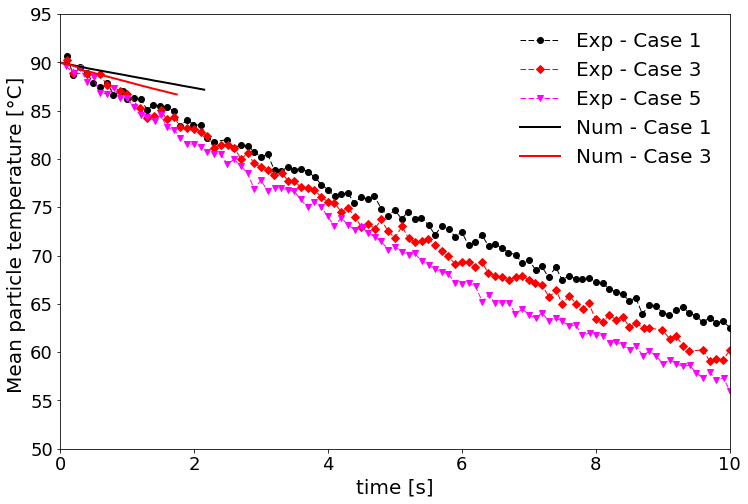

In [44]:
plt.plot(time_case1,  temp_case1, linestyle = "--", color = "black", marker = 'o', linewidth = 1,label = "Exp - Case 1")
plt.plot(time_case3,  temp_case3, linestyle = "--", color = "red", marker = 'D', linewidth = 1,label = "Exp - Case 3")
plt.plot(time_case5,  temp_case5, linestyle = "--", color = "magenta", marker = 'v', linewidth = 1,label = "Exp - Case 5")
plt.plot(time_rocky_case1,  temp_rocky_case1-273.15, linestyle = "-", color = "black", marker = 'None', linewidth = 2,label = "Num - Case 1")
plt.plot(time_rocky_case3,  temp_rocky_case3-273.15, linestyle = "-", color = "red", marker = 'None', linewidth = 2,label = "Num - Case 3")
#plt.title("Vertical velocity ", fontsize = 16)
plt.xlabel("time [s]", fontsize = 20)
plt.ylabel("Mean particle temperature [\u00B0C] ", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20, frameon = False, loc = 0)
plt.xlim(0, 10)     
plt.ylim(50, 95) 
#plt.savefig("bed_temperature.png")
plt.show()

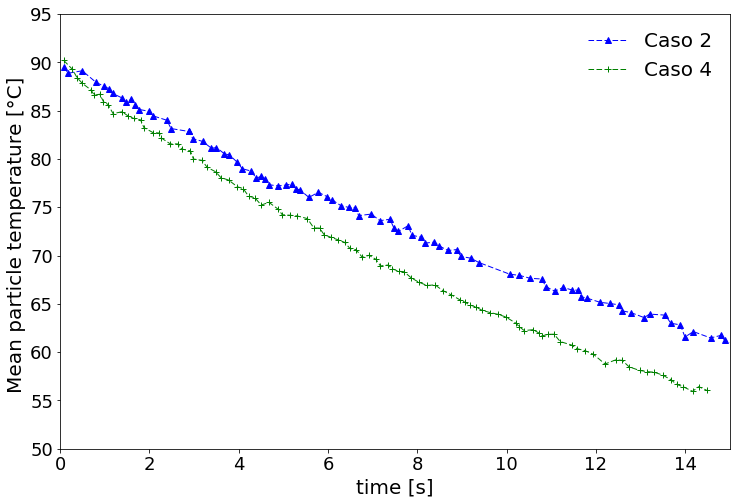

In [45]:
plt.plot(time_case2,  temp_case2, linestyle = "--", color = "blue", marker = '^', linewidth = 1,label = "Caso 2")
plt.plot(time_case4,  temp_case4, linestyle = "--", color = "green", marker = '+', linewidth = 1,label = "Caso 4")
#plt.title("Vertical velocity ", fontsize = 16)
plt.xlabel("time [s]", fontsize = 20)
plt.ylabel("Mean particle temperature [\u00B0C] ", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20, frameon = False, loc = 0)
plt.xlim(0, 15)     
plt.ylim(50, 95) 
#plt.savefig("bed_temperature.png")
plt.show()

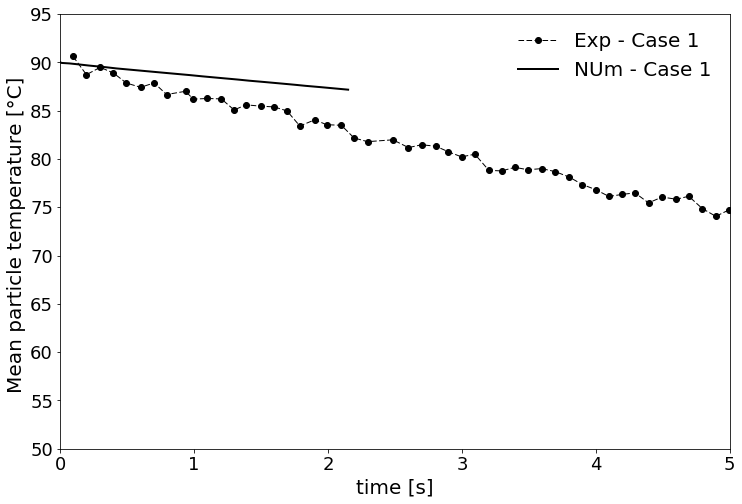

In [46]:
plt.plot(time_case1,  temp_case1, linestyle = "--", color = "black", marker = 'o', linewidth = 1,label = "Exp - Case 1")
plt.plot(time_rocky_case1,  temp_rocky_case1-273.15, linestyle = "-", color = "black", marker = 'None', linewidth = 2,label = "NUm - Case 1")
#plt.title("Vertical velocity ", fontsize = 16)
plt.xlabel("time [s]", fontsize = 20)
plt.ylabel("Mean particle temperature [\u00B0C] ", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20, frameon = False, loc = 0)
plt.xlim(0, 5)     
plt.ylim(50, 95) 
#plt.savefig("bed_temperature.png")
plt.show()

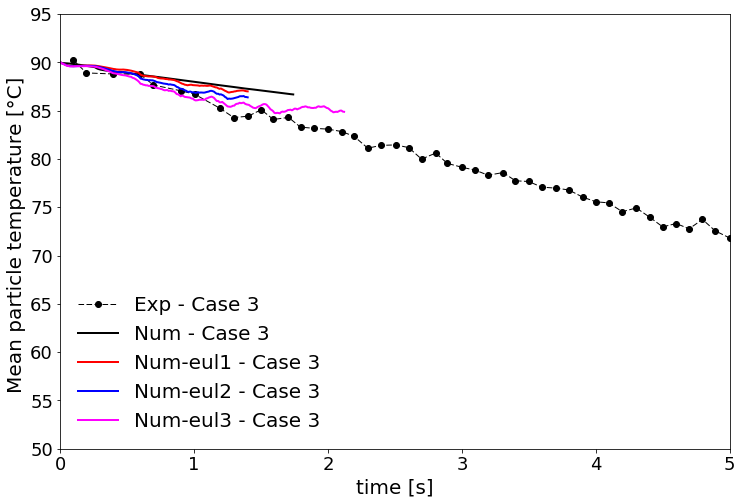

In [47]:
plt.plot(time_case3,  temp_case3, linestyle = "--", color = "black", marker = 'o', linewidth = 1,label = "Exp - Case 3")
plt.plot(time_rocky_case3,  temp_rocky_case3-273.15, linestyle = "-", color = "black", marker = 'None', linewidth = 2,label = "Num - Case 3")
plt.plot(time_rocky_case3_eul,  temp_rocky_case3_eul-273.15, linestyle = "-", color = "red", marker = 'None', linewidth = 2,label = "Num-eul1 - Case 3")
plt.plot(time_rocky_case3_eul2,  temp_rocky_case3_eul2-273.15, linestyle = "-", color = "blue", marker = 'None', linewidth = 2,label = "Num-eul2 - Case 3")
plt.plot(time_rocky_case3_eul3,  temp_rocky_case3_eul3-273.15, linestyle = "-", color = "magenta", marker = 'None', linewidth = 2,label = "Num-eul3 - Case 3")
#plt.title("Vertical velocity ", fontsize = 16)
plt.xlabel("time [s]", fontsize = 20)
plt.ylabel("Mean particle temperature [\u00B0C] ", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20, frameon = False, loc = 0)
plt.xlim(0, 5)     
plt.ylim(50, 95) 
#plt.savefig("bed_temperature.png")
plt.show()

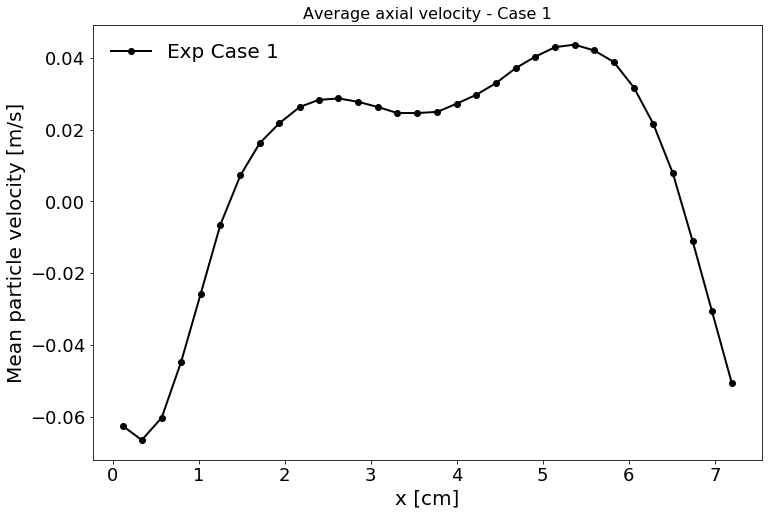

In [102]:
plt.plot(x_case1, volFlux_case1, linestyle = "-", color = "black", marker = 'o', linewidth = 2,label = "Exp Case 1")
plt.title("Average axial velocity - Case 1", fontsize = 16)
plt.xlabel("x [cm]", fontsize = 20)
plt.ylabel("Mean particle velocity [m/s]", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20, frameon = False, loc = 0)
#plt.xlim(0, 15)     
#plt.ylim(50, 90) 
#plt.savefig("bed_temperature.png")
plt.show()

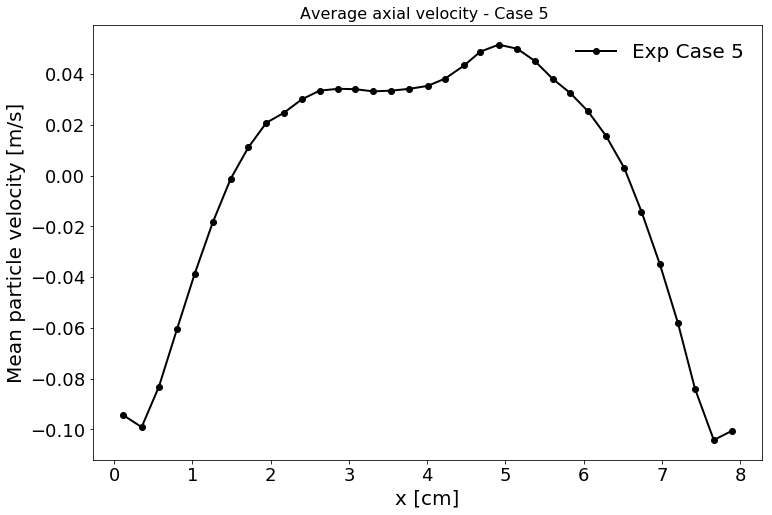

In [103]:
plt.plot(x_case5, volFlux_case5, linestyle = "-", color = "black", marker = 'o', linewidth = 2,label = "Exp Case 5")
plt.title("Average axial velocity - Case 5 ", fontsize = 16)
plt.xlabel("x [cm]", fontsize = 20)
plt.ylabel("Mean particle velocity [m/s]", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 20, frameon = False, loc = 0)
#plt.xlim(0, 15)     
#plt.ylim(50, 90) 
#plt.savefig("bed_temperature.png")
plt.show()